In [120]:
from stumpy.core import (compute_mean_std, sliding_dot_product,
  calculate_distance_profile, apply_exclusion_zone, rolling_window,
                        _mass_absolute)
import numpy as np
from numba import njit
import numba as nb
from numba.typed import List


class ARIMP():
    """
    Compute the Arbitrary-Range-Indexed Matrix Profile (ARIMP)
    Initializes the Arbitrary Range Index with a window and time series (or two if
    A-B-join). Construction is O(n^2) time-complex and has a worst-case space complexity of
    O(n^2), although for many datasets is nearer to O(nlog(n)). After construction, query
    the Matrix Profile for any exclusive or inclusive, relative or absolute range by
    using 'query' method.
    """
    def __init__(self, T, m, Q=None, normalize=True):

        self.T_A = T
        self.m = m

        if Q:
            self.T_B = Q
            self.M_T, self.Σ_T = compute_mean_std(T, m)
            self.μ_Q, self.σ_Q = compute_mean_std(Q, m)
            self.QT = sliding_dot_product(T[:m], Q)
            self.QT_1st = sliding_dot_product(Q[:m], T)

        else:
            self.T_B = T
            self.M_T, self.Σ_T = compute_mean_std(T, m)
            self.μ_Q, self.σ_Q = self.M_T, self.Σ_T
            self.QT = sliding_dot_product(T[:m], T)
            self.QT_1st = np.copy(self.QT)

        self.T_squared = float()
        if not normalize:
          self.T_squared = np.sum(rolling_window(self.T_A * self.T_A, self.m), axis= -1)            
            
        (
          self.SL,
          self.SLI,
          self.SR,
          self.SRI,
          self.RL,
          self.RLI,
          self.LR,
          self.LRI
        ) = _ARIMP(
          self.T_A,
          self.T_B,
          self.m,
          self.QT,
          self.QT_1st,
          self.μ_Q,
          self.σ_Q,
          self.M_T,
          self.Σ_T,
          self.T_squared,
          normalize,
          bool(not Q)
        )


    def query(self, start, end, inclusive=True, absolute=True):

        if inclusive:
            self.P, self.I = _query(
              self.m,
              self.T_A.size,
              start,
              end,
              self.SL,
              self.SLI,
              self.SR,
              self.SRI,
              inclusive,
              absolute
            )

        else:
            self.P, self.I = _query(
              self.m,
              self.T_A.size,
              start,
              end,
              self.RL,
              self.RLI,
              self.LR,
              self.LRI,
              inclusive,
              absolute
            )


        return self.P, self.I



@njit(fastmath=True)
def _ARIMP(T_A, T_B, m, QT, QT_1st, μ_Q, σ_Q, M_T, Σ_T, T_squared, normalize, trivial):
    """
    Constructs set of data structures (the "Arbitrary Range Index") which contain
    the minimum-so-far distances and indexes that allow arbitrary range queries.

    Parameters
    ----------
    T_A : [float] numpy.ndarray
      Time series to query

    T_B : [float] numpy.ndarray
      Time series to query 'T_A'. If self-join ('trivial=True'),
      T_B is T_A.

    m : int
      Window size

    QT : [float] numpy.ndarray
      Sliding dot product

    QT_1st : [float] numpy.ndarray
      First sliding dot product of T_B[:m] and T_A. If self-join ('trivial=True'),
      QT_1st == QT.

    μ_Q: [float] numpy.ndarray
      Moving average of query.

    σ_Q: [float] numpy.ndarray
      Moving standard deviation of query.

    M_T: [float] numpy.ndarray
      Moving average of time series.

    Σ_T: [float] numpy.ndarray
      Moving standard deviation of time series.

    trivial: bool, default True
      Specify self-join ('trivial=True') or A-B-join ('trivial=False')

    Returns
    -------
    Arbitrary_Range_Index : tuple
      Tuple of numba.typed.Lists in which each contain the minimum-so-far distance or
      index needed for a specific query.
    """

    ex = int(np.ceil(m/4))
    if not trivial:
        ex = 0

    L = T_A.size - m + 1
    L_B = T_B.size - m

    copy = lambda x: List([y.copy() for y in x])
    SL = List([List.empty_list(nb.float64) for _ in range(L)])
    SR, RL, LR =  copy(SL),  copy(SL), copy(SL)

    SLI = List([List.empty_list(nb.int64) for _ in range(L)])
    SRI, RLI, LRI = copy(SLI), copy(SLI), copy(SLI)


    for i in range(L):
    # needs to be converted from row-wise to diagonal-wise computation
        if i == 0:
          if normalize:
            D = calculate_distance_profile(m, QT, μ_Q[i], σ_Q[i], M_T, Σ_T)
          else:
            Q = T_B[:m]
            Q_squared = np.sum(Q * Q)
            D = _mass_absolute(Q_squared, T_squared, QT)
        else:
          if normalize:
            QT[1:] = QT[:L_B] - T_A[i-1] * T_B[:L_B] + T_A[i-1+m] * T_B[-L_B:]
            QT[0] = QT_1st[i]
            D = calculate_distance_profile(m, QT, μ_Q[i], σ_Q[i], M_T, Σ_T)
          else:
            Q = T_B[i:i+m]
            Q_squared = np.sum(Q * Q)
            D = _mass_absolute(Q_squared, T_squared, QT)
            
        if ex != 0: apply_exclusion_zone(D, i, ex)

        _get_SL(D, i, L, SL, SLI) # easily parallelized
        _get_SR(D, i, L, SR, SRI)
        _get_LR(D, i, L, LR, LRI)
        _get_RL(D, i, L, RL, RLI)

    return (SL, SLI, SR, SRI, RL, RLI, LR, LRI)


@njit(fastmath=True)
def _get_SL(D, i, L, SL, SLI):
    """Get right-to-left minimum-so-far for inclusive query"""
    for j in range(i+1):
        j = i - j
        if D[j] == np.inf:
            continue
        if len(SL[i]) == 0:
            SL[i].append(D[j])
            SLI[i].append(j)
        if D[j] < SL[i][-1]:
            SL[i].append(D[j])
            SLI[i].append(j)

@njit(fastmath=True)
def _get_SR(D, i, L, SR, SRI):
    """Get left-to-right minimum-so-far for inclusive query"""
    for j in range(L - i):
        j = j + i
        if D[j] == np.inf:
            continue
        if len(SR[i]) == 0:
            SR[i].append(D[j])
            SRI[i].append(j)
        if D[j] < SR[i][-1]:
            SR[i].append(D[j])
            SRI[i].append(j)

@njit(fastmath=True)
def _get_LR(D, i, L, LR, LRI):
    """Get left-to-right minimum-so-far for exclusive query"""
    for j in range(L):
        if D[j] == np.inf:
            continue
        if len(LR[i]) == 0:
            LR[i].append(D[j])
            LRI[i].append(j)
        if D[j] < LR[i][-1]:
            LR[i].append(D[j])
            LRI[i].append(j)

@njit(fastmath=True)
def _get_RL(D, i, L, RL, RLI):
    """Get right-to-left minimum-so-far for exclusive query"""
    for j in range(L):
        j = L-1 - j
        if D[j] == np.inf:
            continue
        if len(RL[i]) == 0:
            RL[i].append(D[j])
            RLI[i].append(j)
        if D[j] < RL[i][-1]:
            RL[i].append(D[j])
            RLI[i].append(j)


@njit(fastmath=True)
def _query(m, n, start, end, L, LI, R, RI, inclusive=True, absolute=True):
    """
    Query the Arbitrary Range Index to find the corresponding Matrix Profile

    Parameters
    ----------
    m : int
      Window size

    n : int
      Length of time series

    start : int
      Start index of inclusion/exclusion zone

    end : int
      End index of inclusion/exclusion zone

    L : [float] numba.typed.List
      List of right-to-left minimum-so-far distances

    LI : [int] numba.typed.List
      List of right-to-left minimum-so-far indexes

    R : [float] numba.typed.List
      List of left-to-right minimum-so-far distances

    RI : [int] numba.typed.List
      List of left-to-right minimum-so-far indexes

    inclusive : bool, default True
      Specify an inclusive or exclusive ('inclusive=False') zone

    absolute : bool, default True
      Specify an absolute or relative ('absolute=False') query. If true, 'start' and
      'end' refer to exact indexes of inclusion/exclusion zone. If false, 'start'/'end'
      refer to distance left/right of sliding search query.

    Returns:
    --------
      P : [float] numpy.ndarray
        The matrix profile

      I : [int] numpy.ndarray
        The matrix profile indexes
    """


    s, e = int(np.abs(start)), end

    if absolute:
        incl_range = range(s, e-m+1)
        excl_range = range(s), range(e+1, n-m+1)
    else:
        incl_range = range(n-m+1)
        excl_range = range(n-m+1), range(0)

    if inclusive:
        SL, SLI, SR, SRI = L, LI, R, RI
        P, I = np.zeros(len(incl_range)), np.zeros(len(incl_range),dtype=np.int64)
        j = 0
        for i in incl_range:

            if absolute:
                SL_num = s
                SR_num = e-m+1
            else:
                SL_num = i-s+1
                SR_num = i+e-1

            
            num = SL_num
            A = SLI[i]
            left = 0
            right = len(A) - 1

            while left <= right:
                mid = (left + right) // 2
                if A[mid] == num:
                  right = mid
                  break
                if A[mid] < num:
                    right = mid-1
                else:
                    left = mid+1
            
            if right >=0:
                iL = right
                vL = SL[i][iL]
            else:
                vL = np.inf

            
            num = SR_num
            A = SRI[i]
            left = 0
            right = len(A) - 1

            while left <= right:
                mid = (left + right) // 2
                if A[mid] == num:
                  right = mid
                  break
                if A[mid] > num:
                    right = mid-1
                else:
                    left = mid+1

            if right >= 0:
                iR = right
                vR = SR[i][iR]
            else:
                vR = np.inf

                
            if vL < vR:
                P[j] += vL
                I[j] += SLI[i][iL]
            elif vR < vL:
                P[j] += vR
                I[j] += SRI[i][iR]
            else:
                P[j] += np.inf
                I[j] += -1
            j += 1


    else:
        RL, RLI, LR, LRI = L, LI, R, RI
        P = np.zeros(len(excl_range[0]) + len(excl_range[1]))
        I = np.zeros(len(excl_range[0]) + len(excl_range[1]), dtype=np.int64)
        j = 0
        for r in excl_range:
            for i in r:

                if absolute:
                    RL_num = e
                    LR_num = s
                else:
                    RL_num = i+e
                    LR_num = i-s


                num = RL_num
                A = RLI[i]
                left = 0
                right = len(A) - 1

                while left <= right:
                    mid = (left + right) // 2
                    if A[mid] == num-1:
                      right = mid
                      break
                    if A[mid] < num:
                        right = mid-1
                    else:
                        left = mid+1

                if right >=0:
                    iR = right
                    vR = RL[i][iR]
                else:
                    vR = np.inf


                num = LR_num
                A = LRI[i]
                left = 0
                right = len(A) - 1

                while left <= right:
                    mid = (left + right) // 2
                    if A[mid] == num+1:
                      right = mid
                      break
                    if A[mid] > num:
                        right = mid-1
                    else:
                        left = mid+1

                if right >= 0:
                    iL = right
                    vL = LR[i][iL]
                else:
                    vL = np.inf


                if vL < vR:
                    P[j] += vL
                    I[j] += LRI[i][iL]
                elif vR < vL:
                    P[j] += vR
                    I[j] += RLI[i][iR]
                else:
                    P[j] += np.inf
                    I[j] += -1
                j += 1

    return P, I


In [122]:
%matplotlib inline
import dask, distributed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stumpy

from itertools import chain
itr = chain.from_iterable

dclient = distributed.Client()
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [123]:
DATA = pd.read_csv("stumpy/walking_data2.csv", header=None, names=['Date', 'Ppl'])
data = DATA.Ppl.values.astype(float)

In [6]:
dfs = []
for year in ["2015", "2016", "2017"]:
    for month in ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]:
        url = f"http://www.pedestrian.melbourne.vic.gov.au/datadownload/{month}_{year}.csv"
        df = pd.read_csv(url)
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True).loc[:, ["Date", "Hour", "Collins Place (North)"]]

In [124]:
ARI_MP = ARIMP(data, 120)
stump_MP = stumpy.stumped(dclient, data, 120)

In [6]:
ARI_MP = ARIMP(df['Collins Place (North)'].values.astype(float), 120)

stump_MP = stumpy.stumped(dclient, df['Collins Place (North)'].values.astype(float), 120)

KeyboardInterrupt: 

In [134]:
from IPython.display import Image
from functools import partial
import os
def img(x):
  p = os.getcwd()
  _img = partial(Image, width=500, embed=True)
  return _img(f'{p}/images/arimp_paper/{x}.png')


True

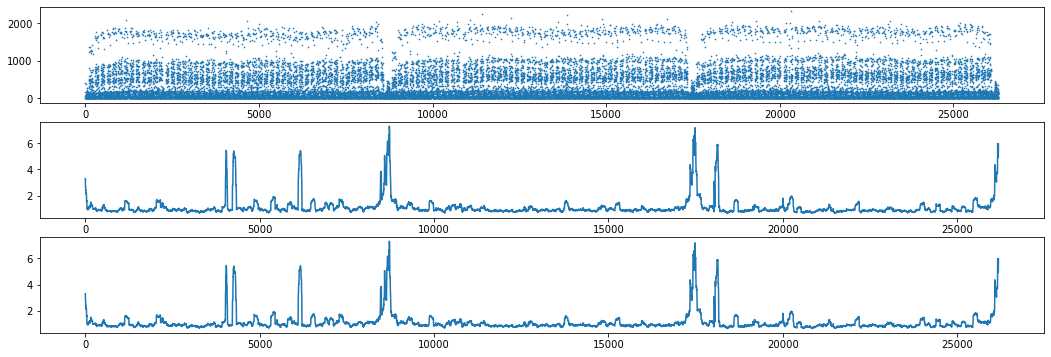

In [130]:
# Fig. 4 (11 in ext.)
# some discrepancy between paper and standard STUMP; there are three peaks in mid 2015 that the paper doesn't show. Nothing in data (holidays etc) to suggest the peaks, and rescraped the dataset with a different method and used different MP algorithms and got same results. Does not affect the ARI queries

plt.figure(42, (18,6))
plt.subplot(311)
plt.scatter(range(len(data)), data, s=.4)
plt.subplot(312)
plt.plot(stump_MP[:,0])
plt.subplot(313)
plt.plot(ARI_MP.query(0,len(data))[0])

np.allclose(stump_MP[:,:2].astype(float).T, ARI_MP.query(0, len(data)))

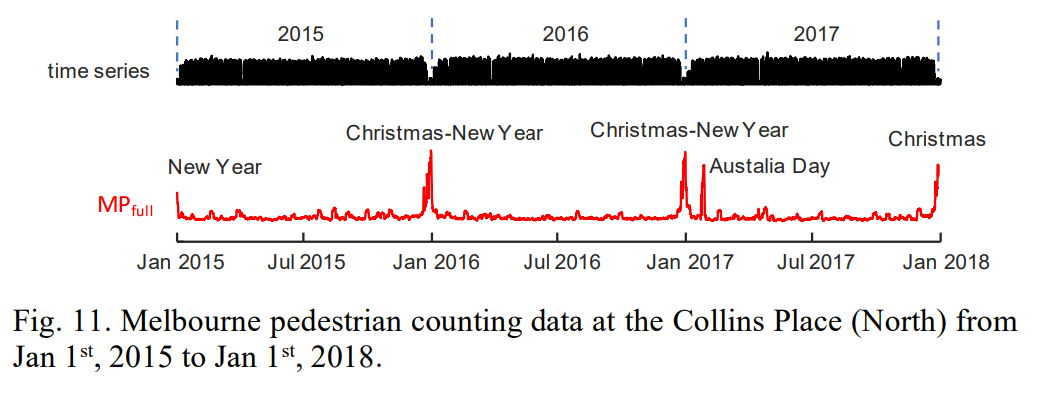

In [138]:
img('case1a')

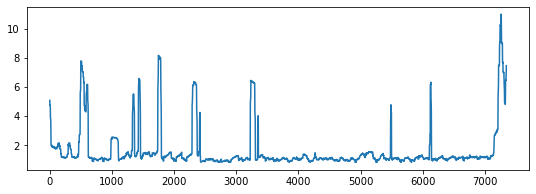

In [125]:
dates = pd.to_datetime(DATA.Date, dayfirst=True)

# Fig. 7 (Fig. 14 in extended paper)
months = dates[dates.dt.year==2016].groupby(dates.dt.month)
month_dist = [np.zeros(m[1].index[-1]-m[1].index[0]-120+1) for m in months]
month_idx = [x.copy() for x in month_dist]
for i, m in enumerate(months):
    mp = ARI_MP.query(m[1].index[0],m[1].index[-1])
    month_dist[i] += mp[0]
    month_idx[i] += mp[1]

plt.figure(42, (9,3))

plt.plot(list(itr(month_dist)))

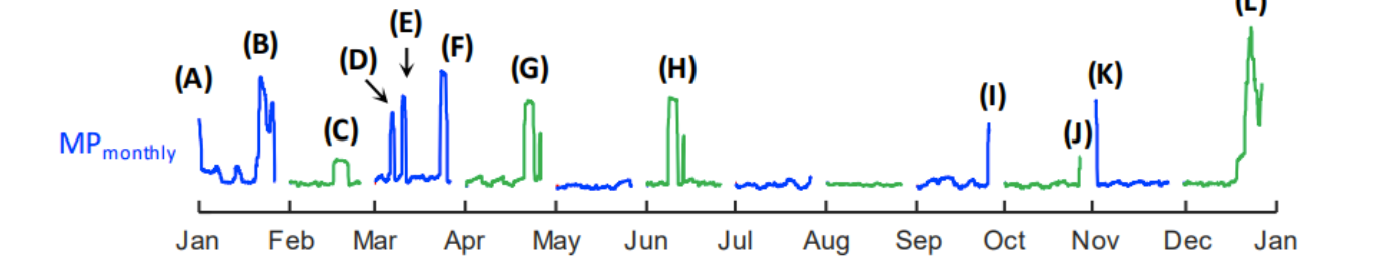

In [136]:
img('case1d')

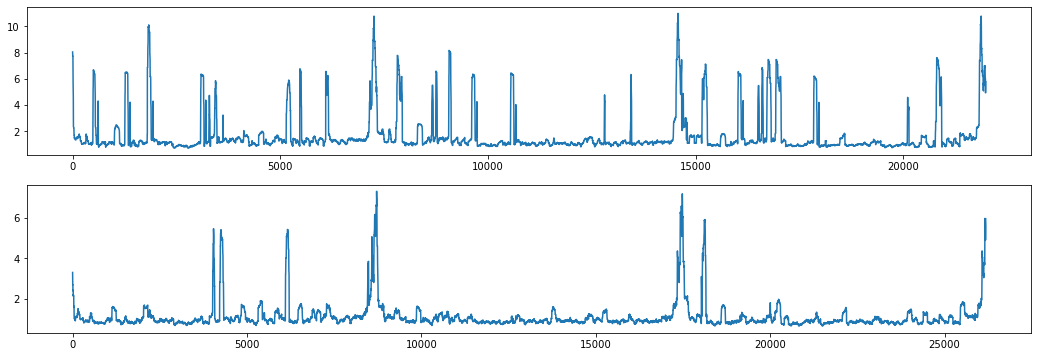

In [126]:
# Fig. 6 (Fig. 13 in ext.)
months = dates.groupby([dates.dt.year,dates.dt.month])
month_dist = [np.zeros(m[1].index[-1]-m[1].index[0]-120+1) for m in months]
month_idx = [x.copy() for x in month_dist]
for i, m in enumerate(months):
    mp = ARI_MP.query(m[1].index[0],m[1].index[-1])
    month_dist[i] += mp[0]
    month_idx[i] += mp[1]

plt.figure(42, (18,6))
plt.subplot(211)
plt.plot(list(itr(month_dist)))
plt.subplot(212)
plt.plot(stump_MP[:,0])

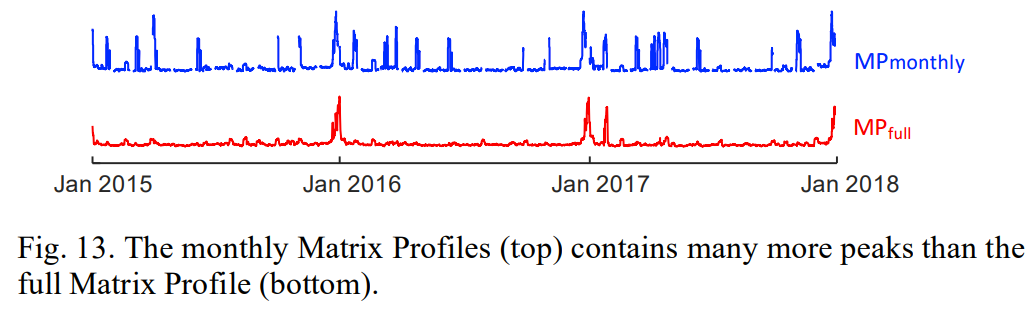

In [137]:
img('case1b')

In [29]:
# Taipei metro data (ext paper.IV.C) ... paper uses hourly data accessed 6/12/2019 
# but the referenced link now only has datasets with daily samples...
# unable to reproduce results
# case study tests the Relative-Inclusive mode of ARI-MP

dfs2= []
for month in range(1,13):
  url = f'https://web.metro.taipei/RidershipPerStation/2016{month:02}_en.ods'
  df = pd.read_excel(url)
  df.columns = [c.strip() for c in df.columns]
  dfs2.append(df[['StationDate', 'Nanjing Fuxing']])
  
df2 = pd.concat(dfs2, ignore_index=True)

m = 4 # 4*24 if hourly was available
stump_MP2 = stumpy.stumped(dclient, df2['Nanjing Fuxing'].values.astype(float), m)
ARI_MP2 = ARIMP(df2['Nanjing Fuxing'].values.astype(float), m)

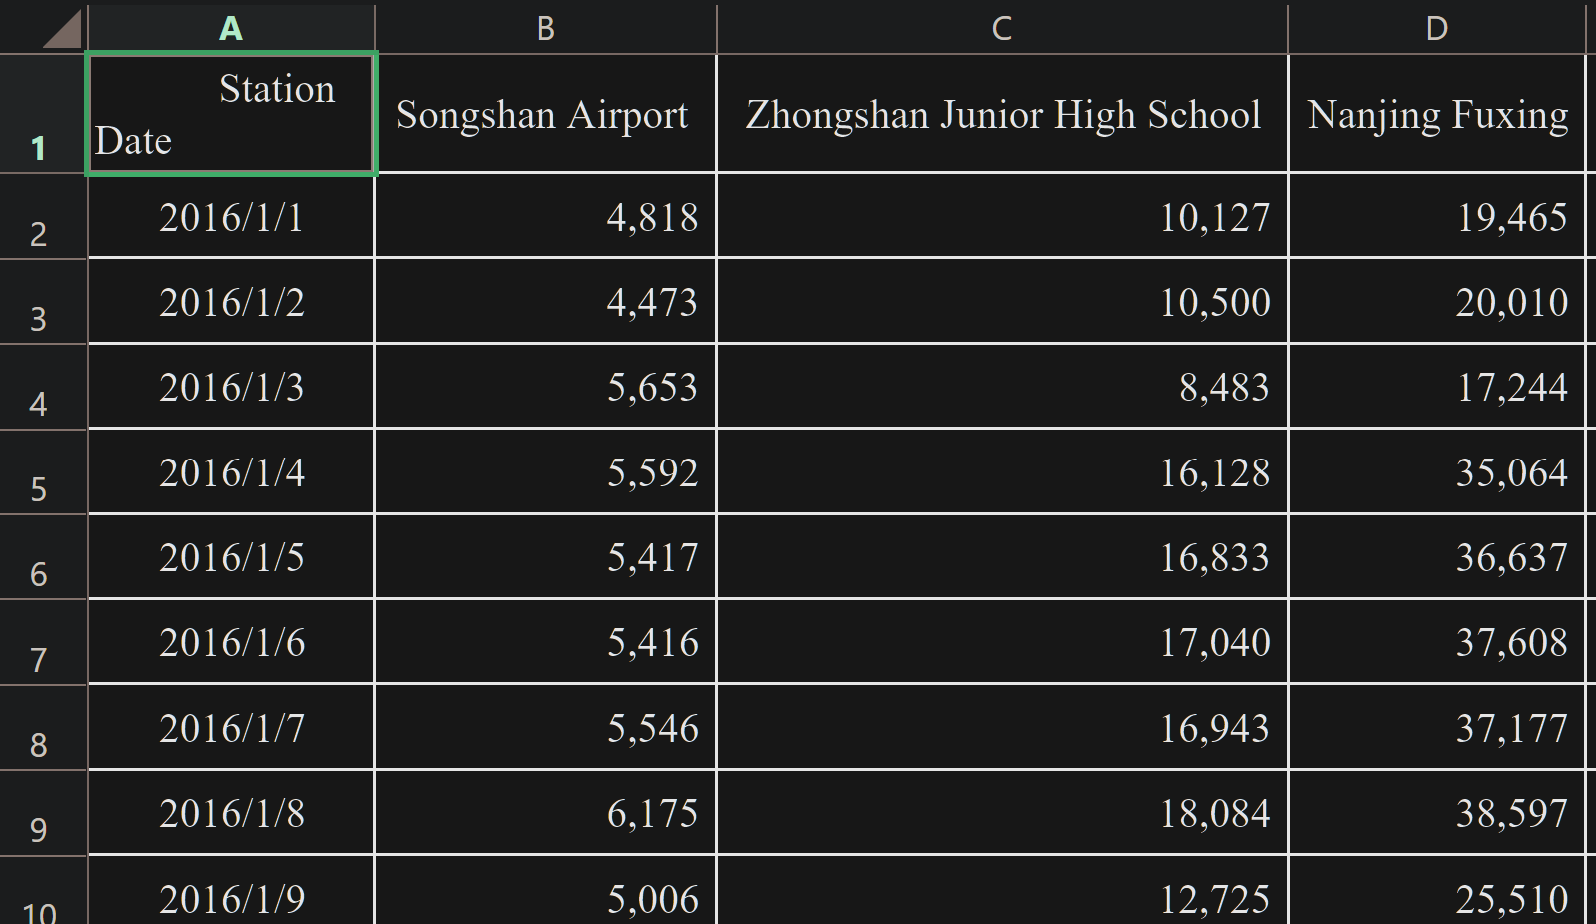

In [139]:
img('case2')

In [140]:
# Electrical Power Demand ext paper.IV.D
# data is 500MB csv in a 500MB 7zip, so relevant rows are attached in power_data.csv
# and power_data1.csv . power_data1 is from 'Clean' dataset (but still contains NaN)
# case study examines the Relative-Inclusion and Relative-Exclusion ARI-MP queries

df3 = pd.read_csv('power_data1.csv')[['Time', 'Appliance1']]
df3 = df3.set_index(pd.to_datetime(df3.Time))[:'2013-10-09'].resample('80s').mean()
values = df3.Appliance1.interpolate().values

#df4 = pd.read_csv('power_data1.csv')[['Time', 'Appliance1']]
#df4 = df4.set_index(pd.to_datetime(df4.Time))[:'2013-10-09'].resample('80s').sum()
#values2 = df4.Appliance1.interpolate().values
#df5 = pd.read_csv('power_data1.csv')[['Time', 'Appliance1']]
#df5 = df5.set_index(pd.to_datetime(df5.Time))[:'2013-10-09']
#values3 = df5.Appliance1.interpolate().rolling(10).mean().iloc[::10].values
#values4 = df5.Appliance1.interpolate().rolling(10).sum().iloc[::10].values
# and tried df.fillna(bfill/ffill)

In [132]:
aamp3 = stumpy.aamped(dclient,values, 180)
stump3 = stumpy.stumped(dclient, values, 180)
ari3_abs = ARIMP(values, 180, normalize=False)
ari3 = ARIMP(values, 180)

### Fig 20, extended paper.IV.D (case study 3), different attempts:

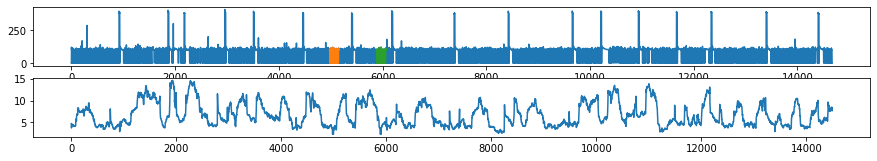

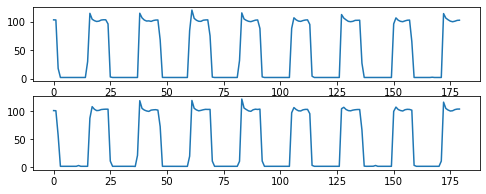

In [141]:
# Fig 20 extpaper.IV.D
# does not give same result as paper. in fact, the paper's top-1 motif
# subsequence resembles the top-1 discord more than top-1 motif.
# changing NaN fill method for dataset gives different but similar results.
# Matrix Profiles are similar but different. also tried non-normalized MP


#note these are results from stumpy.stump's basic MP



motif = np.argmin(stump3[:,0])
motif = (motif, stump3[motif,1])
plt.figure(123, (15,5))
ax1 = plt.subplot(411)
ax1.plot(values)
ax1.plot(range(motif[0],motif[0]+180), values[motif[0]:motif[0]+180])
ax1.plot(range(motif[1],motif[1]+180), values[motif[1]:motif[1]+180])
ax2 = plt.subplot(412)
ax2.plot(stump3[:,0])
fig2 = plt.figure(444, (8,3))
ax3 = plt.subplot(211)
ax3.plot(values[motif[0]:motif[0]+180])
ax4 = plt.subplot(212)
ax4.plot(values[motif[1]:motif[1]+180])

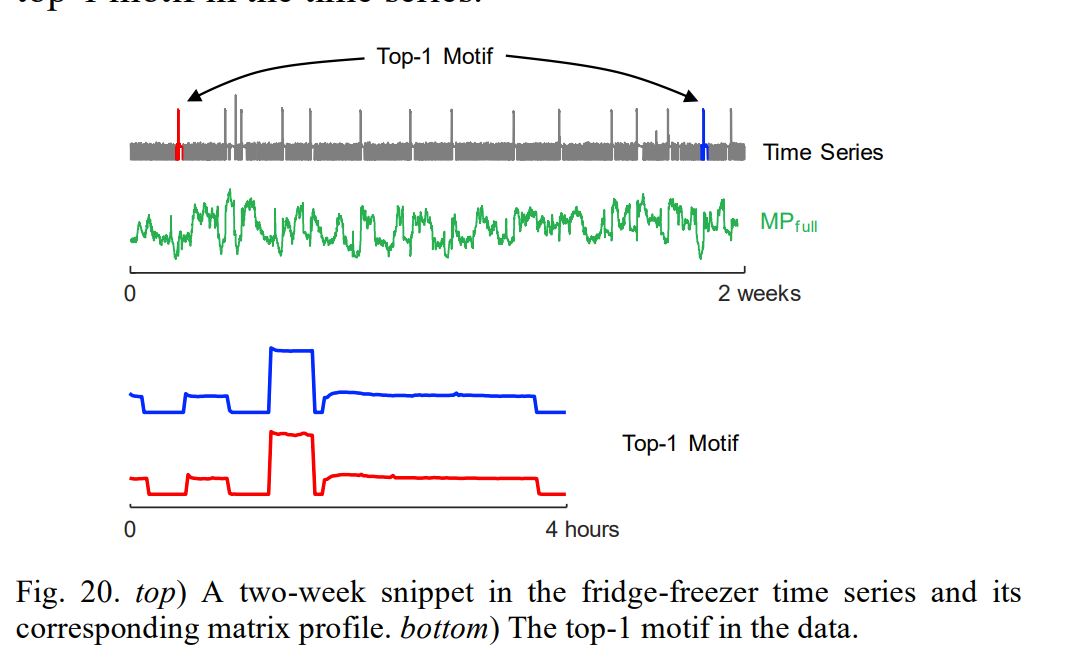

In [20]:
img('case3a')

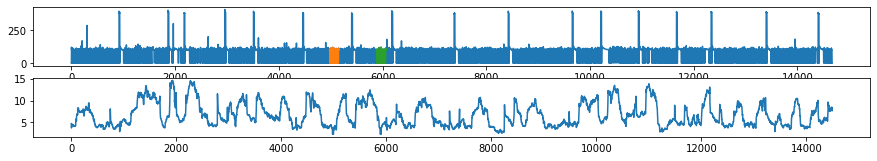

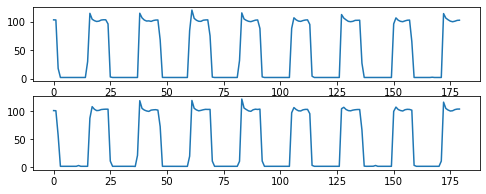

In [143]:
# top-2 discords, somewhat similar to paper's top-1 motif

motif = np.argmin(stump3[:,0])
motif = (motif, stump3[motif,1])
plt.figure(2222, (15,5))
ax1 = plt.subplot(411)
ax1.plot(values)
ax1.plot(range(motif[0],motif[0]+180), values[motif[0]:motif[0]+180])
ax1.plot(range(motif[1],motif[1]+180), values[motif[1]:motif[1]+180])
ax2 = plt.subplot(412)
ax2.plot(stump3[:,0])
fig2 = plt.figure(4444, (8,3))
ax3 = plt.subplot(211)
ax3.plot(values[motif[0]:motif[0]+180])
ax4 = plt.subplot(212)
ax4.plot(values[motif[1]:motif[1]+180])

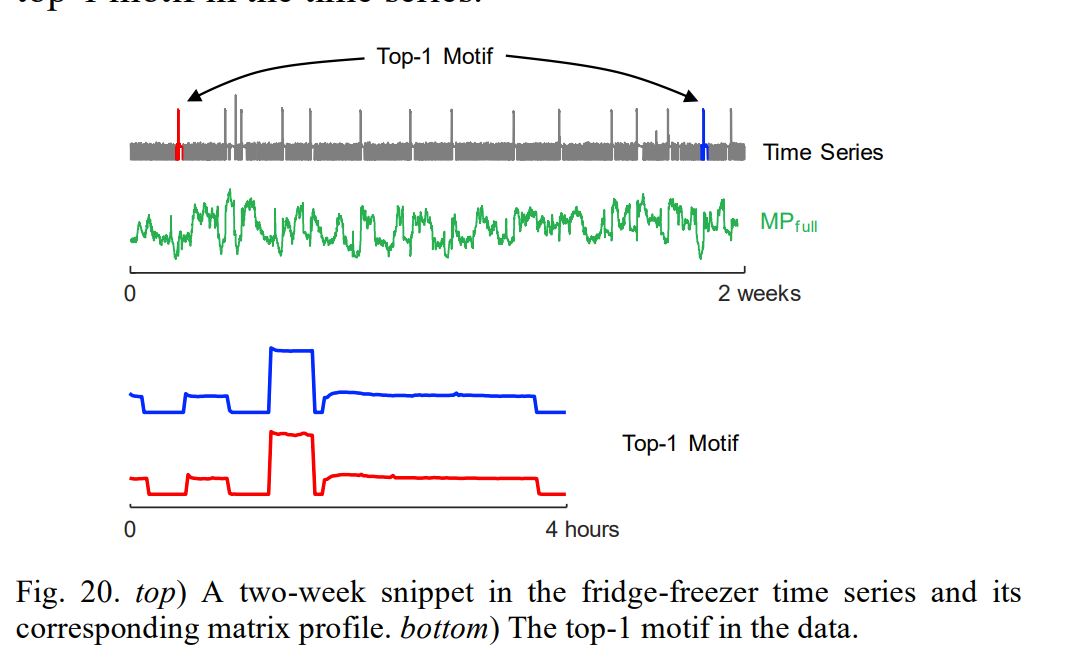

In [21]:
img('case3a')

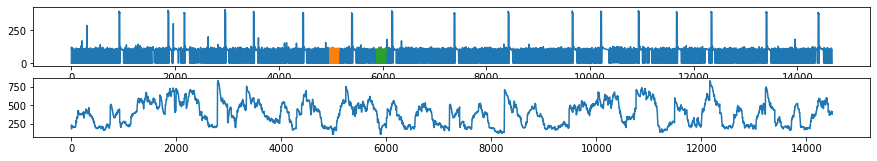

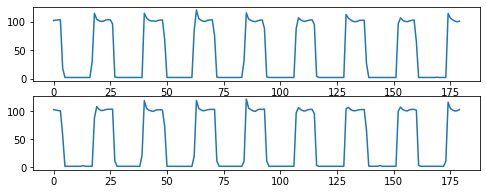

In [97]:
# AAMP, MP is slightly more similar to paper but not motif

motif = np.argmin(aamp3[:,0])
motif = (motif, aamp3[motif,1])
plt.figure(123, (15,5))
ax1 = plt.subplot(411)
ax1.plot(values)
ax1.plot(range(motif[0],motif[0]+180), values[motif[0]:motif[0]+180])
ax1.plot(range(motif[1],motif[1]+180), values[motif[1]:motif[1]+180])
ax2 = plt.subplot(412)
ax2.plot(aamp3[:,0])
fig2 = plt.figure(444, (8,3))
ax3 = plt.subplot(211)
ax3.plot(values[motif[0]:motif[0]+180])
ax4 = plt.subplot(212)
ax4.plot(values[motif[1]:motif[1]+180])

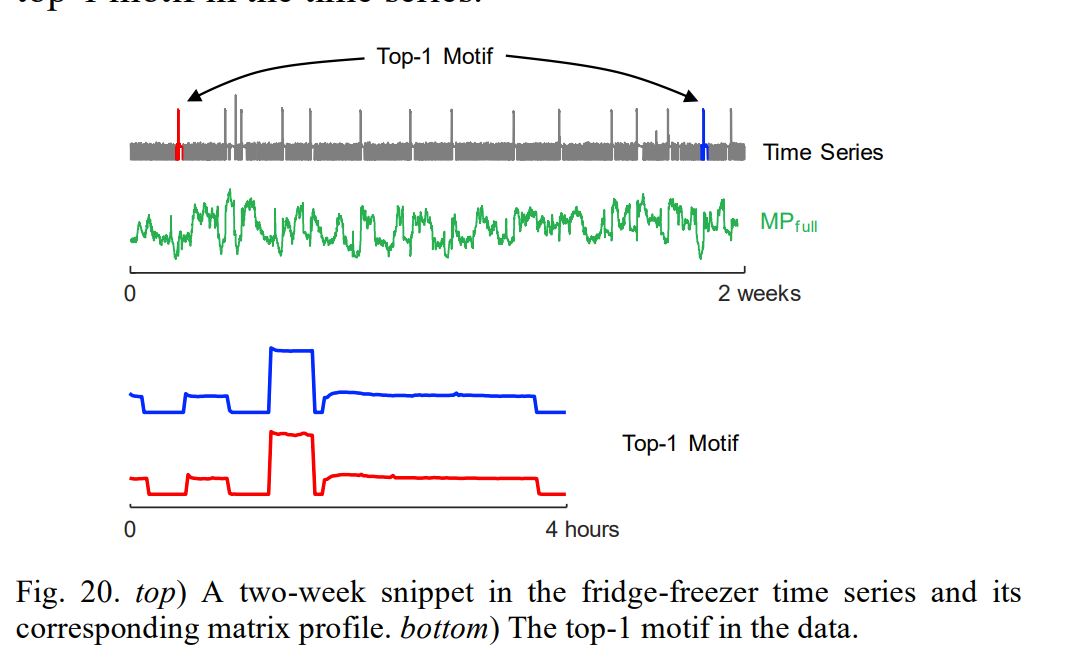

In [23]:
img('case3a')

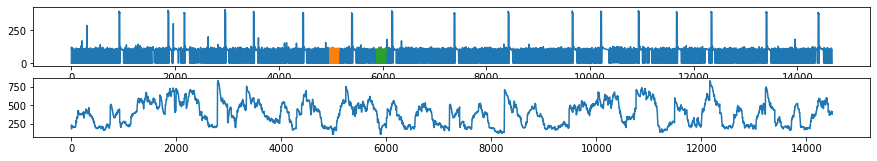

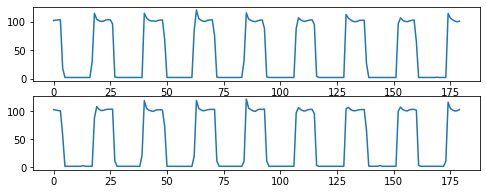

In [142]:
# top-2 discords AAMP, different from paper

motif = np.argmin(aamp3[:,0])
motif = (motif, aamp3[motif,1])
plt.figure(2222, (15,5))
ax1 = plt.subplot(411)
ax1.plot(values)
ax1.plot(range(motif[0],motif[0]+180), values[motif[0]:motif[0]+180])
ax1.plot(range(motif[1],motif[1]+180), values[motif[1]:motif[1]+180])
ax2 = plt.subplot(412)
ax2.plot(aamp3[:,0])
fig2 = plt.figure(4444, (8,3))
ax3 = plt.subplot(211)
ax3.plot(values[motif[0]:motif[0]+180])
ax4 = plt.subplot(212)
ax4.plot(values[motif[1]:motif[1]+180])

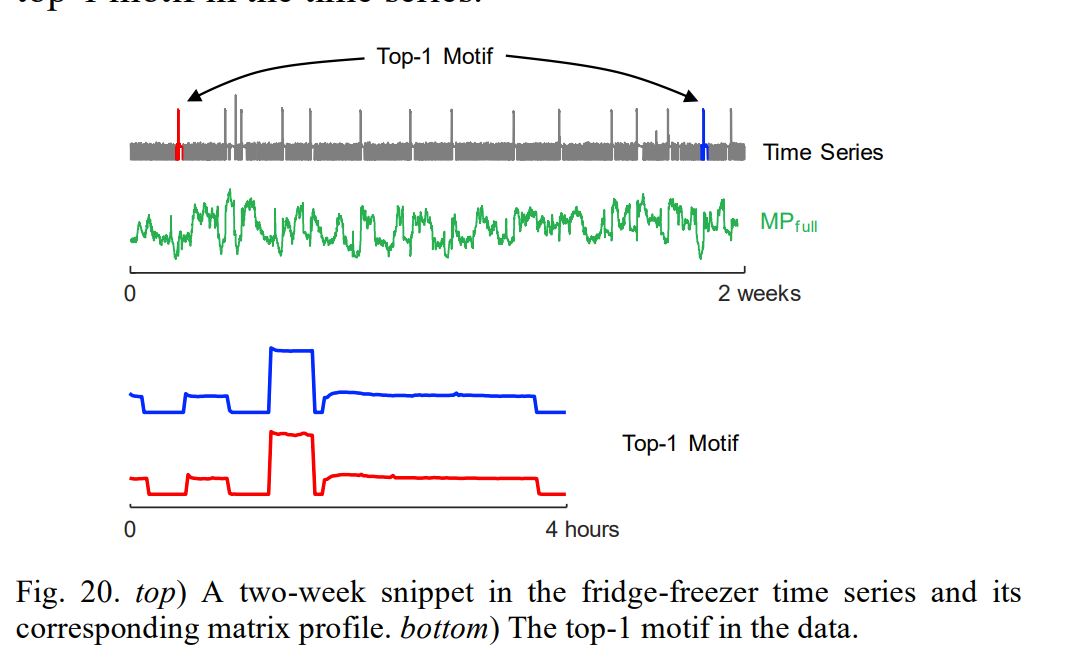

In [22]:
img('case3a')

### Fig 21-22

In [144]:
# Fig 21, similar but different
r = 8 * 60 * 60 / 80 #hours * minutes * seconds * Hz

mp8hr = ari3.query(r,r, absolute=False, inclusive=True)
motif = np.argmin(mp8hr[0])
motif = (motif, mp8hr[1][motif])
m1,m2 = motif[0], motif[1]

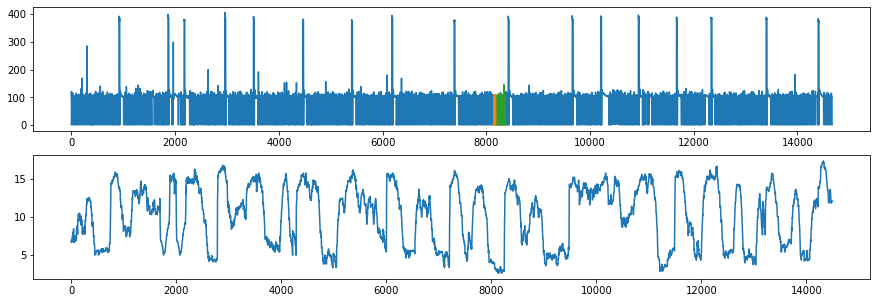

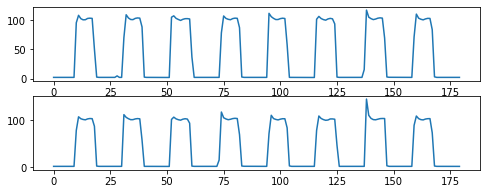

In [145]:
plt.figure(1, (15,5))
plt.subplot(211)
plt.plot(values)
plt.plot(range(m1,m1+180),values[m1:m1+180])
plt.plot(range(m2,m2+180),values[m2:m2+180])
plt.subplot(212)
plt.plot(mp8hr[0])
fig2 = plt.figure(4444, (8,3))
ax3 = plt.subplot(211)
ax3.plot(values[m1:m1+180])
ax4 = plt.subplot(212)
ax4.plot(values[m2:m2+180])

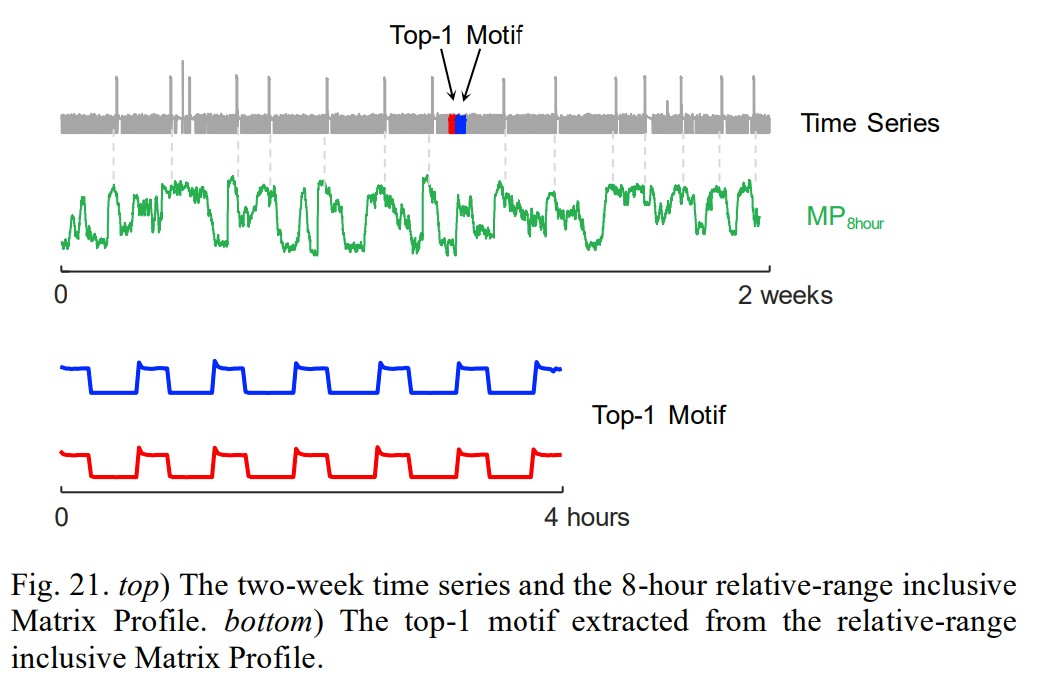

In [106]:
img('case3b')

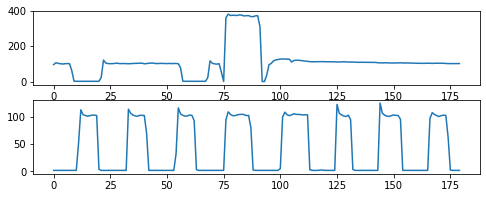

In [146]:
#fig 22, somewhat similar. 

discord = mp8hr[0].argmax()
d1,d2 = discord, mp8hr[1][discord]
plt.figure(888, (8,3))
plt.subplot(211)
plt.plot(values[d1:d1+180])
plt.subplot(212)
plt.plot(values[d2:d2+180])

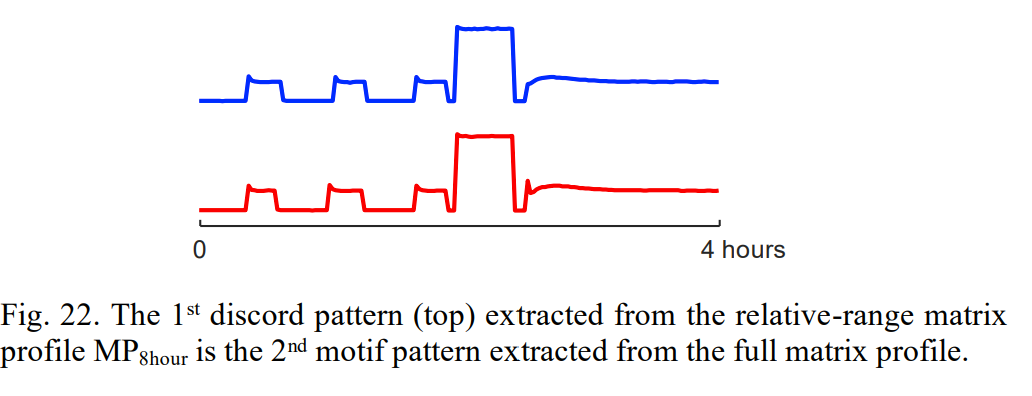

In [120]:
img('case3c')